In [1]:
%matplotlib inline

from asteria import config, source
from asteria.neutrino import Flavor


import astropy.units as u

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import sys
import tables
import pickle

In [2]:
conf = config.load_config('../../data/config/test.yaml')
ccsn = source.initialize(conf)

In [3]:
# Define neutrino energy spectrum
E_min = 0.1; E_max = 100.1; dE = 0.1;
Enu = np.arange(E_min, E_max, dE) * u.MeV

# Define post-bounce times at which to evaluate
t_min = -1; t_max = 15; dt = 0.0001;
time = np.arange(t_min, t_max, dt) * u.s

In [127]:
class Binning(tables.IsDescription):
    start  = tables.Float64Col()   
    stop   = tables.Float64Col() 
    step   = tables.Float64Col()
    nSteps = tables.Int64Col()
    
class Flavors(tables.IsDescription):
    nu_e     = tables.BoolCol(dflt=False)
    nu_e_bar = tables.BoolCol(dflt=False)
    nu_x     = tables.BoolCol(dflt=False)
    nu_x_bar = tables.BoolCol(dflt=False)

class Interactions(tables.IsDescription):
    InvBetaTab      = tables.BoolCol(dflt=False)
    InvBetaPar      = tables.BoolCol(dflt=False)
    ElectronScatter = tables.BoolCol(dflt=False)
    Oxygen16CC      = tables.BoolCol(dflt=False)
    Oxygen16NC      = tables.BoolCol(dflt=False)
    Oxygen18        = tables.BoolCol(dflt=False)

class Configuration(tables.IsDescription):
    flavors      = Flavors()
    interactions = Interactions()

1) Get path form configs, then alter `config.py` with new variable data for hdfs path

## Writing `h5` File from Scratch

In [130]:
try:
    h5file.close()
except NameError:
    print( "h5 File not open yet")
    
finally:
    ofile = '/'.join([conf.abs_base_path, 'processed/test.h5'])
    h5file = tables.open_file( filename=ofile, mode='w', title='Generated from ASTERIA configuration file: test.yaml' )


group_config = h5file.create_group('/', 'config',
                                   'Requested Simulation configuration' )
table_tbins = h5file.create_table(group_config, 'Time',
                                  Binning, 'Signature time binning [s]' )
table_Ebins = h5file.create_table(group_config, 'Enu',
                                  Binning, 'Neutrino spectrum energy binning [MeV]' )  
table_Flavors = h5file.create_table(group_config, 'Flavors',
                                    Flavors, 'Requested Neutrino Flavors' )
table_Interactions = h5file.create_table(group_config, 'Interactions',
                                         Interactions, 'Requested Neutrino Interactions' )
 
nu = table_Flavors.row
for flavor in Flavor:
    nu[ flavor.name ] = True
nu.append()
table_Flavors.flush()

interactions = table_Interactions.row
interactions['InvBetaPar'] = True
interactions['ElectronScatter'] = True
interactions['Oxygen16CC'] = True
interactions['Oxygen16NC'] = True
interactions['Oxygen18'] = True
interactions.append()
table_Interactions.flush()

tBins = table_tbins.row
tBins['step']   = dt
tBins['start']  = t_min
tBins['stop']   = t_max
tBins['nSteps'] = time.size
tBins.append()
table_tbins.flush()

eBins = table_Ebins.row
eBins['start']  = E_min
eBins['stop']   = E_max
eBins['step']   = dE
eBins['nSteps'] = Enu.size
eBins.append()
table_Ebins.flush()

data = h5file.create_group("/", 'E_per_V', 
                           'ASTERIA output: Photonic energy per ice volume [MeV / m^3]')
for flavor in Flavor:
    vlarray_flavor = h5file.create_vlarray(data, flavor.name,
                                           tables.Float64Atom(shape=()),
                                           'Flavor: '+flavor.name )
    vlarray_flavor.append( np.ones( 4 ))

print(h5file)
h5file.close()

/data/ASTERIA/data/processed/test.h5 (File) 'Generated from ASTERIA configuration file: test.yaml'
Last modif.: 'Tue Mar 26 18:52:07 2019'
Object Tree: 
/ (RootGroup) 'Generated from ASTERIA configuration file: test.yaml'
/E_per_V (Group) 'ASTERIA output: Photonic energy per ice volume [MeV / m^3]'
/E_per_V/nu_e (VLArray(1,)) 'Flavor: nu_e'
/E_per_V/nu_e_bar (VLArray(1,)) 'Flavor: nu_e_bar'
/E_per_V/nu_x (VLArray(1,)) 'Flavor: nu_x'
/E_per_V/nu_x_bar (VLArray(1,)) 'Flavor: nu_x_bar'
/config (Group) 'Requested Simulation configuration'
/config/Enu (Table(1,)) 'Neutrino spectrum energy binning [MeV]'
/config/Flavors (Table(1,)) 'Requested Neutrino Flavors'
/config/Interactions (Table(1,)) 'Requested Neutrino Interactions'
/config/Time (Table(1,)) 'Signature time binning [s]'



## Appending to existing `h5` File.

In [131]:
try:
    h5file.close()
except NameError:
    print( "h5 File not open yet")    
finally:
    h5file = tables.open_file( filename=ofile, mode='a' )


table_Flavors = h5file.root.config.Flavors
nu = table_Flavors.row
for flavor in Flavor:
    nu[ flavor.name ] = True
    break
nu.append()
table_Flavors.flush()


table_Interactions = h5file.root.config.Interactions
interactions = table_Interactions.row
interactions['InvBetaTab'] = True
interactions.append()
table_Interactions.flush()

table_tbins = h5file.root.config.Time
tBins = table_tbins.row
tBins['step']   = dt
tBins['start']  = t_min
tBins['stop']   = t_max - 1
tBins['nSteps'] = time.size
tBins.append()
table_tbins.flush()

table_Ebins = h5file.root.config.Enu
eBins = table_Ebins.row
eBins['start']  = E_min + 1
eBins['stop']   = E_max
eBins['step']   = dE
eBins['nSteps'] = Enu.size
eBins.append()
table_Ebins.flush()

for flavor in Flavor:  
    vlarray = h5file.root.E_per_V[ flavor.name ]
    vlarray.append( np.ones(3) )

    
print(  h5file )
h5file.close()

/data/ASTERIA/data/processed/test.h5 (File) 'Generated from ASTERIA configuration file: test.yaml'
Last modif.: 'Tue Mar 26 18:52:10 2019'
Object Tree: 
/ (RootGroup) 'Generated from ASTERIA configuration file: test.yaml'
/E_per_V (Group) 'ASTERIA output: Photonic energy per ice volume [MeV / m^3]'
/E_per_V/nu_e (VLArray(2,)) 'Flavor: nu_e'
/E_per_V/nu_e_bar (VLArray(2,)) 'Flavor: nu_e_bar'
/E_per_V/nu_x (VLArray(2,)) 'Flavor: nu_x'
/E_per_V/nu_x_bar (VLArray(2,)) 'Flavor: nu_x_bar'
/config (Group) 'Requested Simulation configuration'
/config/Enu (Table(2,)) 'Neutrino spectrum energy binning [MeV]'
/config/Flavors (Table(2,)) 'Requested Neutrino Flavors'
/config/Interactions (Table(2,)) 'Requested Neutrino Interactions'
/config/Time (Table(2,)) 'Signature time binning [s]'



## Searching for matching criteria from `h5` file.

Potential problem with time binning, could lead to inefficient I/O if the file is large enough. My main concern is the time binning.

Pass dictionaries for io variables to speed things along (For the user).

In [176]:
try: 
    h5file.close()
except NameError:
    print( "h5 File not open yet")    
finally:
    h5file = tables.open_file( filename=ofile, mode='r' )

    table_Time = h5file.root.config.Time
table_Enu  = h5file.root.config.Enu
table_Flavors = h5file.root.config.Flavors
table_Interactions = h5file.root.config.Interactions



pass_Time = [ row.nrow for row in table_Time.where('stop == 14') ]
pass_Enu  = [ row.nrow for row in table_Enu.where('start == 1.1') ]
pass_Flavors = [ row.nrow for row in table_Flavors.where('nu_e') ]
pass_Interactions = [ row.nrow for row in table_Interactions.where('InvBetaTab') ]
pass_all = list( set(pass_Time).intersection( pass_Enu, pass_Flavors, pass_Interactions) )


print("Rows that pass the Time cuts:", pass_Time)
print("Rows that pass the Enu cuts:", pass_Enu)
print("Rows that pass the flavor cuts:", pass_Flavors)
print("Rows that pass the Interactions cuts:", pass_Interactions)
print("Rows that pass all cuts:", pass_all)

Rows that pass the Time cuts: [1]
Rows that pass the Enu cuts: [1]
Rows that pass the flavor cuts: [0, 1]
Rows that pass the Interactions cuts: [1]
Rows that pass all cuts: [1]


In [69]:
# a = np.array([0], dtype=float )
a = ccsn.luminosity[Flavor.nu_e]
print( sys.getsizeof( a ) )
print( type(a) )

56
<class 'scipy.interpolate.fitpack2.InterpolatedUnivariateSpline'>


In [13]:
total_size = 0
for flavor in Flavor:
    total_size += sys.getsizeof(pickle.dumps(ccsn.pinch[flavor]))
    total_size += sys.getsizeof(pickle.dumps(ccsn.luminosity[flavor]))
    total_size += sys.getsizeof(pickle.dumps(ccsn.mean_energy[flavor]))
print( '{0} MB'.format( total_size/1e6 ) )

5.606984 MB


In [4]:

from enum import Enum, EnumMeta
from asteria import interactions
from asteria.neutrino import Flavor

import astropy.units as u


    
# allowed_interactions = (interactions.InvBetaPar, interactions.InvBetaTab,
#                             interactions.ElectronScatter, interactions.Oxygen16CC,
#                             interactions.Oxygen16NC, interactions.Oxygen18) 

# class InteractionEnum(Enum):
#     def __new__(cls, requested):
#         obj = object.__new__(cls)
#         obj._value_ = None
#         return obj
    
#     def __init__(self, requested):
#         if not self._name_ in ('InvBetaPar', 'InvBetaTab','ElectronScatter',
#                                'Oxygen16CC', 'Oxygen16NC','Oxygen18'):
#             raise NameError('Requested unknown/incorrect Key: {0}'.format( self._name_ ))
#         self._value_ = getattr(interactions, self._name_ )
#         self._requested_ = requested
#         return self
            
    
#     @property
#     def cross_section(self):
#         if not self._requested_:
#             return 0 * u.cm**2
#         return self.value.cross_section
    
#     @property
#     def mean_lepton_energy(self):        
#         if not self._requested_:
#             return 0 * u.MeV**2
#         return self.value.mean_lepton_energy

    
# class InteractionsMeta(EnumMeta):
#     def __new__(metacls, cls, bases, classdict):
#         data = classdict['data']
#         names = [(interaction, data[interaction]) for interaction in data]

#         temp = type(classdict)()
#         excluded = []
#         for name, requested in names:
#             temp[name] = requested
#             if not requested:
#                 excluded.append(name)
        
#         print(classdict['data'] )

#         temp.update(item for item in classdict.items() if classdict['data'] not in excluded)

#         return super(InteractionsMeta, metacls).__new__(metacls, cls, bases, temp)

# class InteractionsMeta(EnumMeta):
#     def __new__(metacls, cls, bases, classdict):
#         requested = classdict['requested']
        
#         obj = type(classdict)()
#         excluded = ['requested']
        
#         for interaction in requested:
#             obj[interaction] = requested[interaction] # Put asteria.interaction class here
#             if requested[interaction]:
#                 excluded.append(interaction)
        
#         obj.update( item for item in classdict.items() if requested not in excluded)
#         print( obj )
#         return super(InteractionsMeta, metacls).__new__(metacls, cls, bases, obj)         
    
# class InteractionsMeta(EnumMeta):
#     def __new__(metacls, cls, bases, classdict):
#         requested = classdict['requested']
#         obj = type(classdict)()
        
#         excluded = ['requested']
#         for item in requested:
#             if requested[item]:
#                 obj[item] = requested[item]
                
#         print(obj)
#         for item in classdict.items():
#             print( item[0] not in excluded )
#         obj.update(item for item in classdict.items() if item[0] not in excluded )
#         print(obj)
#         return super(InteractionsMeta, metacls).__new__(metacls, cls, bases, obj)         
    
# class Interactions(Enum):
#     InvBetaPar      = 1
#     InvBetaTab      = 2
#     ElectronScatter = 3
#     Oxygen16CC      = 4
#     Oxygen16NC      = 5
#     Oxygen18        = 6

In [13]:
dir( Interactions )

['ElectronScatter',
 'InvBetaPar',
 'InvBetaTab',
 'Oxygen16CC',
 'Oxygen16NC',
 'Oxygen18',
 '__class__',
 '__doc__',
 '__members__',
 '__module__']

In [85]:
temp = ['InvBeta', 'ElectronScat']

excluded = set(temp) | set(('data',))
for item in excluded:
    print( item )

ElectronScat
InvBeta
data


In [247]:
def Interactions(InteractionDict = ):
    """ doc string"""
    
    def __init__(cls, name, bases, props):
        cls.__all_values__ = [...] 
        
        
    def __iter__(cls):
        
        return (name for name in cls._member_names_)

    
class InteractionEnum(Enum, metaclass=InteractionsMeta):
    """ doc string"""    
    #print('test1')
    InvBetaPar      = True
    InvBetaTab      = False
    ElectronScatter = True
    Oxygen16CC      = True
    Oxygen16NC      = True
    Oxygen18        = True

    
    def __init__(self, requested):
        #print('Init Object: {0}'.format(self._name_) )
        #print('test3')
        self._requested_ = requested
        self._value_ = getattr(interactions, self._name_ )
    

for item in Interactions:
    print(item)

['__doc__', '__module__', '__qualname__']
InvBetaPar
InvBetaTab
ElectronScatter
Oxygen16CC
Oxygen16NC
Oxygen18


In [233]:
class Interactions(Enum):
    """ doc string"""
    print('Creating Enumeration:')
    _ignore_ = 'ignored'
    
    InvBetaPar      = True
    InvBetaTab      = False
    ElectronScatter = True
    Oxygen16CC      = True
    Oxygen16NC      = True
    Oxygen18        = True
    
    def __contains__(self, requested):
        
        return requested
    
    def __new__(cls, requested):
        print('Inst. Object')
        obj = object.__new__(cls)
        obj._value_ = requested
        return obj
    
    def __init__(self, requested):
        print('Init Object: {0}'.format(self._name_) )
        self._requested_ = requested
        self._value_ = getattr(interactions, self._name_ )

        
    @property
    def cross_section(self):
        return self.value.cross_section
    
    @property
    def mean_lepton_energy(self):
        return self.value.mean_lepton_energy
    
    print('Completed Enum Creation, Returning \n')

print('\n\n***Begin Test********')
for item in Interactions:
    print(item)

Creating Enumeration:
Completed Enum Creation, Returning 

Inst. Object
Init Object: InvBetaPar
Inst. Object
Init Object: InvBetaTab
Inst. Object
Init Object: ElectronScatter
Inst. Object
Init Object: Oxygen16CC
Inst. Object
Init Object: Oxygen16NC
Inst. Object
Init Object: Oxygen18


***Begin Test********
Interactions.InvBetaPar
Interactions.InvBetaTab
Interactions.ElectronScatter
Interactions.Oxygen16CC
Interactions.Oxygen16NC
Interactions.Oxygen18


In [116]:
class InteractionsMeta(EnumMeta):
    default = {'InvBetaPar'      : True,
               'InvBetaTab'      : False,
               'ElectronScatter' : True,
               'Oxygen16CC'      : True,
               'Oxygen16NC'      : True,
               'Oxygen18'        : True }
    
    def __iter__(cls):
        return (getattr(interactions, name) for name in cls._member_names_ 
                if cls._member_map_[name].value['requested'])
    
    def __call__(cls, requests=default, name='Interactions'):
         return cls._create_(name, requests)
        

class Interactions(Enum, metaclass=InteractionsMeta):
    """ doc string"""
    
    def __init__(self, value):
        print('init')
        self._value_ = {'name' : getattr(interactions, self._name_ ).__module__+'.'+self._name_, 
                        'requested' : value }

In [117]:
for a in Interactions():
    print(a)

init
init
init
init
init
init
<class 'asteria.interactions.InvBetaPar'>
<class 'asteria.interactions.ElectronScatter'>
<class 'asteria.interactions.Oxygen16CC'>
<class 'asteria.interactions.Oxygen16NC'>
<class 'asteria.interactions.Oxygen18'>


In [114]:
class InteractionsMeta(EnumMeta):
    default = {'InvBetaPar'      : True,
               'InvBetaTab'      : False,
               'ElectronScatter' : True,
               'Oxygen16CC'      : True,
               'Oxygen16NC'      : True,
               'Oxygen18'        : True }
    
    
    def __iter__(cls):
        return (getattr(interactions, name) for name in cls._member_names_ 
                if cls._member_map_[name].value['requested'])
    
    def __call__(cls, requests=default, name='Interactions'):
          return cls._create_(name, requests)
        

class Interactions(Enum, metaclass=InteractionsMeta):
    """ doc string"""
    
        
 
    
    def __init__(self, value):
        self._value_ = {'name' : getattr(interactions, self._name_ ).__module__+'.'+self._name_, 
                        'requested' : value }

for item in Interactions():
    print(a)

<class 'asteria.interactions.Oxygen18'>
<class 'asteria.interactions.Oxygen18'>
<class 'asteria.interactions.Oxygen18'>
<class 'asteria.interactions.Oxygen18'>
<class 'asteria.interactions.Oxygen18'>


In [54]:
import inspect

print( object.__new__(Enum) )


test = {'InvBetaPar'      : False,
        'InvBetaTab'      : False,
        'ElectronScatter' : True,
        'Oxygen16CC'      : True,
        'Oxygen16NC'      : True,
        'Oxygen18'        : True }


print(bool('Kapootic' in test.keys())  )



print( inspect.getsource(Interactions.__call__.__func__) )


Interactions('req', test)

{'__module__': 'enum', '__doc__': 'Generic enumeration.\n\n    Derive from this class to define new enumerations.\n\n    ', '__new__': <staticmethod object at 0x7feac3331c50>, '_generate_next_value_': <function Enum._generate_next_value_ at 0x7feac333a510>, '_missing_': <classmethod object at 0x7feac3331b00>, '__repr__': <function Enum.__repr__ at 0x7feac333a620>, '__str__': <function Enum.__str__ at 0x7feac333a6a8>, '__dir__': <function Enum.__dir__ at 0x7feac333a730>, '__format__': <function Enum.__format__ at 0x7feac333a7b8>, '__hash__': <function Enum.__hash__ at 0x7feac333a840>, '__reduce_ex__': <function Enum.__reduce_ex__ at 0x7feac333a8c8>, 'name': <types.DynamicClassAttribute object at 0x7feac3331b38>, 'value': <types.DynamicClassAttribute object at 0x7feac3331be0>, '_convert': <classmethod object at 0x7feac3331c18>, '__dict__': <attribute '__dict__' of 'Enum' objects>, '__weakref__': <attribute '__weakref__' of 'Enum' objects>, '_member_names_': [], '_member_map_': OrderedDic

TypeError: Cannot extend enumerations

In [105]:
Enum([1,2,3])

NameError: name 'enum' is not defined

In [ ]:
class InteractionEnum(Enum):
    
    def __init__(self, requested):
        self._value_ = getattr(interactions, self._name_ )
        
    @property
    def cross_section(self):
        return self.value.cross_section
    
    @property
    def mean_lepton_energy(self):
        return self.value.mean_lepton_energy
        
        

class Interactions(InteractionEnum):
    """ doc string"""
   
    InvBetaPar      = True
    InvBetaTab      = False
    ElectronScatter = True
    Oxygen16CC      = True
    Oxygen16NC      = True
    Oxygen18        = True

print('\n\n***Begin Test********')
for item in Interactions:
    print(item)

In [65]:
bool(-1)


True

In [211]:
{'_generate_next_value_': <function Enum._generate_next_value_ at 0x7f2108f51510>, 
 '__module__': '__main__',
 '__doc__': ' doc string',
 '__new__': <function Enum.__new__ at 0x7f2108f51488>,
 '__init__': <function Interactions.__init__ at 0x7f20cc910840>,
 'cross_section': <property object at 0x7f20cc7ad548>,
 'mean_lepton_energy': <property object at 0x7f20cc7ad598>,
 '_member_names_': ['InvBetaPar', 'InvBetaTab', 'ElectronScatter',
                    'Oxygen16CC', 'Oxygen16NC', 'Oxygen18'],
 '_member_map_': OrderedDict([('InvBetaPar', <Interactions.InvBetaPar: <class 'asteria.interactions.InvBetaPar'>>),
                              ('InvBetaTab', <Interactions.InvBetaTab: <class 'asteria.interactions.InvBetaTab'>>),
                              ('ElectronScatter', <Interactions.ElectronScatter: <class 'asteria.interactions.ElectronScatter'>>),
                              ('Oxygen16CC', <Interactions.Oxygen16CC: <class 'asteria.interactions.Oxygen16CC'>>),
                              ('Oxygen16NC', <Interactions.Oxygen16NC: <class 'asteria.interactions.Oxygen16NC'>>),
                              ('Oxygen18', <Interactions.Oxygen18: <class 'asteria.interactions.Oxygen18'>>)]),
 '_member_type_': <class 'object'>, '_value2member_map_': {True: <Interactions.Oxygen18: <class 'asteria.interactions.Oxygen18'>>,
                                                           False: <Interactions.InvBetaTab: <class 'asteria.interactions.InvBetaTab'>>},
 'InvBetaPar': <Interactions.InvBetaPar: <class 'asteria.interactions.InvBetaPar'>>,
 'InvBetaTab': <Interactions.InvBetaTab: <class 'asteria.interactions.InvBetaTab'>>,
 'ElectronScatter': <Interactions.ElectronScatter: <class 'asteria.interactions.ElectronScatter'>>,
 'Oxygen16CC': <Interactions.Oxygen16CC: <class 'asteria.interactions.Oxygen16CC'>>,
 'Oxygen16NC': <Interactions.Oxygen16NC: <class 'asteria.interactions.Oxygen16NC'>>,
 'Oxygen18': <Interactions.Oxygen18: <class 'asteria.interactions.Oxygen18'>>, 
 '__new_member__': <function Interactions.__new__ at 0x7f20cc910c80>} 

True

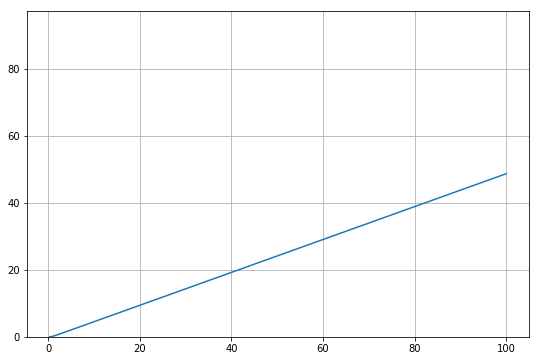

In [36]:
# Define neutrino energy spectrum
E_min = 0.1; E_max = 100.1; dE = 0.1;
Enu = np.arange(E_min, E_max, dE) * u.MeV

# Define post-bounce times at which to evaluate
t_min = -1; t_max = 15; dt = 0.0001;
time = np.arange(t_min, t_max, dt) * u.s

xs = interactions.ElectronScatter().cross_section(Flavor.nu_e, Enu).to(u.m**2).value
lep = interactions.ElectronScatter().mean_lepton_energy(Flavor.nu_e, Enu).to(u.m**2 * u.MeV).value
cut = (lep > 0) & (xs > 0)
quan = lep[cut]/xs[cut]
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.plot( Enu[cut], quan);
ax.grid()
ymin = np.min( quan )
ymax = np.max( quan )        
ax.set( ylim=(ymin/2, ymax*2) );


In [ ]:

from enum import Enum
from asteria import interactions
from asteria.neutrino import Flavor

class InteractionEnum(Enum):
    def __new__(cls, interaction, active):
        obj = object.__new__(cls)
        obj._value_ = interaction            
        
        return obj
#         else: 
#             pass

# requested = [ interactions.InvBetaPar,
#                         interactions.ElectronScatter,
#                         interactions.Oxygen16CC, 
#                         interactions.Oxygen16NC,
#                         interactions.Oxygen18 ]

class Interactions(InteractionEnum):
    """Neutrino interactions.

    .. data:: InvBetaPar
        Parameterized inverse beta decay.

    .. data:: InvBetaTab
        Tabulated inverse beta decay.

    .. data:: ElectronScatter
        Elastic neutrino-electron scattering.

    .. data:: Oxygen16CC
        O16 charged-current interaction.

    .. data:: Oxygen16NC
        O16 neutral-current interaction

    .. data:: Oxygen18
        O18 charged-current interaction

    """    
    InvBetaPar      = (interactions.InvBetaPar(), True)
    InvBetaTab      = (interactions.InvBetaTab(), False)
    ElectronScatter = (interactions.ElectronScatter(), True)
    Oxygen16CC      = (interactions.Oxygen16CC(), True)
    Oxygen16NC      = (interactions.Oxygen16NC(), True)
    Oxygen18        = (interactions.Oxygen18(), True)
    
    def __init__(self, interaction, active):
        self.cross_section      = interaction.cross_section
        self.mean_lepton_energy = interaction.mean_lepton_energy

    
    #     _ignore_ = [ item._name_ for item in self if not item.value[1]]
    @property
    def is_InvBetaPar(self):
        return isinstance(self.value, (interactions.InvBetaPar))

    @property
    def is_InvBetaTab(self):
        return isinstance(self.value, (interactions.InvBetaTab))

    @property
    def is_ElectronScatter(self):
        return isinstance(self.value, (interactions.ElectronScatter))

    @property
    def is_Oxygen16CC(self):
        return isinstance(self.value, (interactions.Oxygen16CC))

    @property
    def is_Oxygen16NC(self):
        return isinstance(self.value, (interactions.Oxygen16NC))

    @property
    def is_Oxygen18(self):
        return isinstance(self.value, (interactions.Oxygen18))
    

#     print(interaction.value.cross_section(Flavor.nu_e, Enu).to(u.m**2).value)